In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import re
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import regularizers

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.columns.values)
print(train_df.shape, test_df.shape)
print(train_df.columns[train_df.isna().any()].tolist())
print(test_df.columns[test_df.isna().any()].tolist())
train_df.head()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
(891, 12) (418, 11)
['Age', 'Cabin', 'Embarked']
['Age', 'Fare', 'Cabin']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def cabin_feature(dfp):

    dfp["hascabin"] = dfp["Cabin"].isna().astype(int)
    dfp["cabin_let"] = dfp["Cabin"].astype(str).str[0]
    dfp["cabin_num"] = dfp["Cabin"].astype(str).str[1:]
    index_cabin_num = dfp.loc[dfp['cabin_num'].str.isdigit(), :].index
    dfp["cabin_first_num"] = "n"
    dfp.loc[index_cabin_num, "cabin_first_num"] = dfp.loc[index_cabin_num,'cabin_num'].astype(str).str[0]
    dfp.drop('cabin_num', axis=1, inplace=True)
    
    return dfp

In [4]:
df_dummy = train_df
df_dummy = cabin_feature(df_dummy)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hascabin,cabin_let,cabin_first_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,n,n
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,C,8
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,n,n
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,n,n


In [5]:
def get_title(name):

    tsrc = re.search(' ([A-Za-z]+)\.', name)
    if tsrc:
            return tsrc.group(1)
    return "None"

def name_feature(dfp):

    dfp['title'] = dfp['Name'].apply(get_title)
    reg_map = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Rare', 'Sir': 'Rare', 'Rev': 'Rare',
               'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Rare', 'Lady': 'Mrs',
               'Capt': 'Rare', 'Countess': 'Rare', 'Ms': 'Miss', 'Dona': 'Rare'}
    dfp.replace({'title': reg_map}, inplace=True)
    title_map = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4, "None":5}
    dfp['title'] = dfp['title'].map(title_map)
    dfp['title'] = dfp['title'].fillna(5)

    return dfp

In [6]:
df_dummy = name_feature(df_dummy)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hascabin,cabin_let,cabin_first_num,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,n,n,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,C,8,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,n,n,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,C,1,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,n,n,0.0


In [7]:
def family_feature(dfp):
    
    dfp['family_size'] = dfp['SibSp'] + dfp['Parch'] + 1
    dfp['isfam'] = 1
    dfp.loc[dfp['family_size'] == 1, 'isfam'] = 0
    
    return dfp

In [8]:
df_dummy = family_feature(df_dummy)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hascabin,cabin_let,cabin_first_num,title,family_size,isfam
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,n,n,0.0,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,C,8,2.0,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,n,n,1.0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,C,1,2.0,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,n,n,0.0,1,0


In [9]:
def fare_feature(dfp):

    dfp['fare_free'] = 0
    index_free_fare = dfp[dfp['Fare'] == 0].index
    dfp.loc[index_free_fare, 'fare_free'] = 1
    dfp.loc[index_free_fare, 'Fare'] = np.nan
    dfp['Fare'] = dfp['Fare'].fillna(dfp['Fare'].median())
    dfp['Fare'] = np.log(np.log(dfp['Fare']))
    dfp['fare_ctg'] = 0
    dfp.loc[ dfp['Fare'] <= 7.91, 'fare_ctg'] = 0
    dfp.loc[(dfp['Fare'] > 7.91) & (dfp['Fare'] <= 14.454), 'fare_ctg'] = 1
    dfp.loc[(dfp['Fare'] > 14.454) & (dfp['Fare'] <= 31), 'fare_ctg'] = 2
    dfp.loc[ dfp['Fare'] > 31, 'fare_ctg'] = 3
    dfp['fare_ctg'] = dfp['fare_ctg'].astype(int)
    
    return dfp

In [10]:
df_dummy = fare_feature(df_dummy)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hascabin,cabin_let,cabin_first_num,title,family_size,isfam,fare_free,fare_ctg
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0.683603,NaN,S,1,n,n,0.0,2,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.450832,C85,C,0,C,8,2.0,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0.727559,NaN,S,1,n,n,1.0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.379314,C123,S,0,C,1,2.0,2,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0.735091,NaN,S,1,n,n,0.0,1,0,0,0


In [11]:
def sex_code(dfp):

    dfp["Sex"] = dfp["Sex"].replace({"male": 1, "female": 0})
    return dfp 

In [12]:
df_dummy = sex_code(df_dummy)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hascabin,cabin_let,cabin_first_num,title,family_size,isfam,fare_free,fare_ctg
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.683603,NaN,S,1,n,n,0.0,2,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,1.450832,C85,C,0,C,8,2.0,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.727559,NaN,S,1,n,n,1.0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,1.379314,C123,S,0,C,1,2.0,2,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.735091,NaN,S,1,n,n,0.0,1,0,0,0


In [13]:
def encode_ohe(dfp, list_feature_to_encode, threshold):
    feature_to_encode = [col for col in dfp.columns if col in list_feature_to_encode]
    for cc in feature_to_encode:
        val_count = dfp[cc].value_counts()
        list_one_hot = [val for val in val_count.index if val_count[val] >= threshold and val != "n"] 
        index_users_val_in_list = dfp[dfp[cc].isin(list_one_hot)].index
        dummy_temp = pd.get_dummies(dfp.loc[index_users_val_in_list, cc], prefix=cc)
        dfp = pd.merge(dfp, dummy_temp, left_index = True, right_index = True, how="left")
        dfp.drop(cc, axis=1, inplace=True)
        list_one_hot_new_columns = [col for col in dfp.columns if cc in col]
        dfp[list_one_hot_new_columns] = dfp[list_one_hot_new_columns].fillna(0)  
    return dfp

In [14]:
list_feature_to_encode = ["cabin_let", "cabin_first_num", "Embarked", "title"]
df_dummy = encode_ohe(df_dummy, list_feature_to_encode, 10)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,cabin_first_num_5,cabin_first_num_6,cabin_first_num_7,cabin_first_num_8,cabin_first_num_9,title_0.0,title_1.0,title_2.0,title_3.0,title_4.0
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.683603,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,1.450832,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.727559,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,1.379314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.735091,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
def handle_nan(dfp):

    list_col_nan = ['hascabin','family_size','isfam']
    list_actual_col_nan = [col for col in dfp.columns if col in list_col_nan]
    for col in list_actual_col_nan:
        dfp[col] = dfp[col].fillna(dfp[col].mean())

    list_add_na_col = ['Age']    
    list_actual_add_na_col = [col for col in dfp.columns if col in list_add_na_col]

    for col in list_actual_add_na_col:
        missing_col_name = col + "_na"
        dfp[missing_col_name] = 0
        index_missing_values_for_col = dfp[dfp[col].isnull()].index
        dfp.loc[index_missing_values_for_col, missing_col_name] = 1

    return dfp

In [16]:
df_dummy = handle_nan(df_dummy)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,cabin_first_num_6,cabin_first_num_7,cabin_first_num_8,cabin_first_num_9,title_0.0,title_1.0,title_2.0,title_3.0,title_4.0,Age_na
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.683603,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,1.450832,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.727559,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,1.379314,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.735091,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [17]:
def ticket_feature(dfp, target_col, n_ticket, tick_surv):

    index_with_ticket_digits = dfp.loc[dfp['Ticket'].str.isdigit(), :].index
    dfp["ticket_integer"] = 0
    dfp.loc[index_with_ticket_digits, "ticket_integer"] = 1
    dfp = ticket_replace(dfp, n_ticket, 'NTicket')
    dfp = ticket_replace(dfp, tick_surv, 'TicketSurv')
    return dfp

def ticket_replace(dfp, replace_param, new_col_name):
    
    dfp[new_col_name] = dfp['Ticket'].replace(replace_param)
    dfp.loc[~dfp['Ticket'].isin(replace_param.index),new_col_name] = 0
    dfp[new_col_name] = dfp[new_col_name].fillna(0)
    return dfp

def get_train_ticket_information(dfpt, target_col):

    boy = (dfpt['Name'].str.contains('Master')) | ((dfpt['Sex']==0) & (dfpt['Age']<13))
    female = (dfpt['Sex']==1)
    boy_or_female = boy | female   
    n_ticket = dfpt[boy_or_female].groupby('Ticket')[target_col].count()
    tick_surv = dfpt[boy_or_female].groupby('Ticket')[target_col].mean()
    return n_ticket, tick_surv


In [18]:
target_col = 'Survived'
n_ticket, tick_surv = get_train_ticket_information(df_dummy, target_col)
df_dummy = ticket_feature(df_dummy, target_col, n_ticket, tick_surv)
df_dummy

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,cabin_first_num_9,title_0.0,title_1.0,title_2.0,title_3.0,title_4.0,Age_na,ticket_integer,NTicket,TicketSurv
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.683603,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,1.450832,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.727559,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,1.379314,...,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1,0.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.735091,...,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,0.941939,...,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,1.224128,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,1.148947,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,1,0.0
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,1.224128,...,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,1.0


In [19]:
def age_nan(dfp):
    if dfp['Age'].isna().any() == False:
        return dfp
    variabellll = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Age']
    indievar = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
    dfp_with_age = dfp[pd.isnull(dfp['Age']) == False]
    dfp_with_age = dfp_with_age[variabellll]
    dfp_without_age = dfp[pd.isnull(dfp['Age'])]
    dfp_without_age = dfp_without_age[variabellll]
    regr = RandomForestRegressor()
    regr.fit(dfp_with_age[indievar], dfp_with_age['Age'])
    generatedvalue = regr.predict(X = dfp_without_age[indievar])
    dfp_without_age['Age'] = generatedvalue.astype(int)
    datagen = dfp_with_age.append(dfp_without_age)
    datagen.reset_index(inplace=True)
    dfp['Age'] = datagen['Age']
    return dfp

In [20]:
df_dummy = age_nan(df_dummy)
print(df_dummy.columns[df_dummy.isna().any()].tolist())
df_dummy

['Cabin']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,cabin_first_num_9,title_0.0,title_1.0,title_2.0,title_3.0,title_4.0,Age_na,ticket_integer,NTicket,TicketSurv
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.683603,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,1.450832,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.727559,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,1.379314,...,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1,0.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.735091,...,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,24.0,0,0,211536,0.941939,...,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",0,13.0,0,0,112053,1.224128,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,25.0,1,2,W./C. 6607,1.148947,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,1,0.0
889,890,1,1,"Behr, Mr. Karl Howell",1,27.0,0,0,111369,1.224128,...,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,1.0


In [21]:
def age_feature(dfp, threshold):

    dfp['boy'] = (dfp['Name'].str.contains('Master')) | ((dfp['Sex']==0) & (dfp['Age']<13))
    dfp['age_ctg'] = 0
    dfp.loc[ dfp['Age'] <= 16, 'age_ctg'] = 5
    dfp.loc[(dfp['Age'] > 16) & (dfp['Age'] <= 32), 'age_ctg'] = 1
    dfp.loc[(dfp['Age'] > 32) & (dfp['Age'] <= 48), 'age_ctg'] = 2
    dfp.loc[(dfp['Age'] > 48) & (dfp['Age'] <= 64), 'age_ctg'] = 3
    dfp.loc[dfp['Age'] > 64, 'age_ctg'] = 4
    dfp['age_class_ctg'] = dfp['age_ctg'] * dfp['Pclass']
    dfp = encode_ohe(dfp,['age_ctg','age_class_ctg'],threshold)
    
    return dfp

In [22]:
df_dummy = age_feature(df_dummy, 10)
df_dummy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,age_ctg_5,age_class_ctg_1,age_class_ctg_2,age_class_ctg_3,age_class_ctg_4,age_class_ctg_5,age_class_ctg_6,age_class_ctg_9,age_class_ctg_10,age_class_ctg_15
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.683603,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,1.450832,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.727559,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,1.379314,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.735091,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
list_ord = ["fare_ctg", "age_ctg", "age_class_ctg"]
df_dummy_1 = df_dummy
df_dummy_1 = encode_ohe(df_dummy_1, list_ord, 10)
df_dummy_1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,age_class_ctg_1,age_class_ctg_2,age_class_ctg_3,age_class_ctg_4,age_class_ctg_5,age_class_ctg_6,age_class_ctg_9,age_class_ctg_10,age_class_ctg_15,fare_ctg_0
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.683603,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,1.450832,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.727559,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,1.379314,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.735091,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,24.0,0,0,211536,0.941939,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
887,888,1,1,"Graham, Miss. Margaret Edith",0,13.0,0,0,112053,1.224128,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,25.0,1,2,W./C. 6607,1.148947,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
889,890,1,1,"Behr, Mr. Karl Howell",1,27.0,0,0,111369,1.224128,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [24]:
def preprocessing_dfp(dfp, list_act, list_ord, threshold, target_col, coldrop, n_ticket, tick_surv):

    dfp = cabin_feature(dfp)
    dfp = name_feature(dfp)
    dfp = family_feature(dfp)
    dfp = fare_feature(dfp)
    dfp = sex_code(dfp)
    list_act_feature = [col for col in dfp.columns if col in list_act]
    dfp = encode_ohe(dfp, list_act_feature, threshold)
    dfp = handle_nan(dfp)
    dfp = ticket_feature(dfp, target_col, n_ticket, tick_surv)
    dfp = age_nan(dfp)
    dfp = age_feature(dfp, threshold)
    list_ord_feature = [col for col in dfp.columns if col in list_ord]
    dfp = encode_ohe(dfp, list_ord_feature, threshold)
    coldrops = [col for col in dfp.columns if col in coldrop]
    dfp.drop(coldrops, axis=1, inplace=True)
    dfp = dfp.set_index("PassengerId")
    return dfp

def apply_PCA(df_train, df_test, target_col, components_PCA='no'):
    if components_PCA == 'no':
        return df_train, df_test
    else: 
        no_component = int(round(len(df_test.columns) * components_PCA))
    
    train = df_train.iloc[:,1:].values
    test = df_test.values
    pca = PCA(n_components = no_component)
    principalComponents_train = pca.fit_transform(train)
    principalComponents_test = pca.transform(test)
    principalDf_train = pd.DataFrame(data = principalComponents_train, index = df_train.index)
    finalDf_train = pd.concat([df_train[[target_col]], principalDf_train], axis = 1)
    finalDf_test = pd.DataFrame(data = principalComponents_test, index = df_test.index)
    return finalDf_train, finalDf_test

def preprocessing_train_test_df(train_df, test_df, list_act, list_ord, coldrop, target_col, components_PCA):

    n_ticket, tick_surv = get_train_ticket_information(train_df, target_col)

    preprocessed_train_df = preprocessing_dfp(train_df, list_act, list_ord, 10, target_col, coldrop, n_ticket, tick_surv)
    preprocessed_test_df = preprocessing_dfp(test_df, list_act, list_ord, 0, target_col, coldrop, n_ticket, tick_surv)

    list_col_test_and_train = [col for col in preprocessed_test_df.columns if col in preprocessed_train_df.columns]
    preprocessed_test_df = preprocessed_test_df[list_col_test_and_train]
    list_col_train_not_test = [col for col in preprocessed_train_df.columns if col not in preprocessed_test_df.columns and col != target_col]

    for missing_col in list_col_train_not_test:
        preprocessed_test_df[missing_col] = 0

    #scaler = MinMaxScaler()
    scaler = RobustScaler()
    preprocessed_train_df[preprocessed_test_df.columns] = scaler.fit_transform(preprocessed_train_df[preprocessed_test_df.columns])
    preprocessed_test_df[preprocessed_test_df.columns] = scaler.transform(preprocessed_test_df[preprocessed_test_df.columns])

    preprocessed_train_df, preprocessed_test_df = apply_PCA(preprocessed_train_df, preprocessed_test_df, target_col, components_PCA)
    return preprocessed_train_df, preprocessed_test_df

def create_train_test_data(train_path, test_path, list_act, list_ord, coldrop, target_col, components_PCA, test_split_rat):

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    preprocessed_train_df, preprocessed_test_df = preprocessing_train_test_df(train_df, test_df, list_act, list_ord, coldrop, target_col, components_PCA)

    X = preprocessed_train_df.iloc[:,1:].values
    y = preprocessed_train_df.iloc[:,0].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_rat, random_state=42)

    return X_train, X_test, y_train, y_test, preprocessed_test_df, preprocessed_train_df


In [25]:
list_act = ["cabin_let", "cabin_first_num", "Embarked", "title"]
list_ord = ["fare_ctg", "age_ctg", "age_class_ctg"]
coldrop = ["Name", "Ticket", "Cabin"]
target_col = "Survived"
train_path = "train.csv"
test_path = "test.csv"
test_split_rat = 0.3
components_PCA = 0.75

X_train, X_test, y_train, y_test, dfpre_test, dfpre_train = create_train_test_data(train_path, test_path, list_act, list_ord, coldrop, target_col, components_PCA, test_split_rat)

In [26]:
X_train

array([[ 1.5424303 ,  1.69523302,  0.92312942, ...,  0.15504525,
         0.07920963, -0.19521593],
       [-1.26606429, -0.90211712, -1.35964448, ...,  0.0143199 ,
         0.00652711, -0.02921605],
       [ 1.59516401, -0.77803836, -0.35068805, ...,  0.02913596,
         0.03467544,  0.01991627],
       ...,
       [ 1.4188272 , -1.0196901 ,  1.2971602 , ..., -0.0112819 ,
         0.01561635,  0.00736439],
       [ 2.80750779,  1.86034243,  0.68204372, ...,  0.13417247,
         0.0811165 ,  0.02270222],
       [ 0.09738583,  1.70521463,  0.71816907, ...,  0.03480841,
        -0.11490163, -0.07665569]])

In [27]:
X_test

array([[ 1.79935150e+00, -8.30034236e-01,  8.82858827e-01, ...,
         1.84339383e-03,  2.76451130e-04, -6.67209021e-02],
       [-1.25826089e+00,  1.17998866e-01, -5.78998879e-01, ...,
         2.99939697e-03,  2.13590426e-02, -4.15769372e-02],
       [-1.27629907e+00, -1.03037208e+00, -5.90451583e-01, ...,
        -7.71475130e-03, -7.00656151e-03,  9.09831147e-03],
       ...,
       [-1.20589469e+00,  1.36489494e+00,  7.17126324e-01, ...,
        -1.91633059e-02, -1.24348452e-02, -6.26305661e-02],
       [-1.28380966e+00, -1.05249014e+00, -3.20661023e-01, ...,
        -4.85601109e-03, -1.33731831e-02,  2.57686705e-02],
       [-1.17717764e+00,  1.46467093e+00, -9.04803757e-01, ...,
        -2.29623579e-01, -1.73027947e-01, -3.73787366e-02]])

In [28]:
dfpre_train

,Survived,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,0.126685,-1.081827,-0.772760,-0.575096,-0.321413,-0.447242,-0.266940,-0.613689,-0.087222,...,0.033365,-0.021921,-0.056403,-0.002245,-0.022998,0.024113,0.038085,-0.019130,0.020502,0.013731
2,1,0.443489,2.093521,1.019378,-0.129598,-0.658402,0.659885,0.502586,-0.211673,-0.457181,...,-0.082440,-0.082584,0.021892,-0.175701,0.063837,0.040102,0.031143,0.867919,-0.244078,0.111091
3,1,-1.108593,-0.743523,-0.624644,0.925846,-0.879287,0.024007,-0.632114,-0.277456,0.324227,...,0.047785,-0.070476,-0.036728,-0.001081,0.001108,-0.014420,0.016335,0.011034,-0.023046,0.000554
4,1,0.428757,1.875341,0.904876,-0.192552,-0.336955,0.636713,-0.791779,0.232255,-0.441530,...,0.032303,-0.046272,-0.167776,-0.152668,0.010113,-0.143420,-0.046812,-0.036305,-0.136394,-0.024004
5,0,-1.279660,-1.044113,0.780051,-0.286109,0.613734,0.447411,-0.237121,0.223923,-0.464198,...,-0.027917,-0.018533,0.000945,-0.009669,-0.002615,0.006002,-0.019585,0.001631,0.003993,-0.011538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,-1.164737,0.272732,-0.401490,-0.005229,-0.072779,-0.208240,-0.674096,0.332557,-0.214210,...,0.703101,0.104436,0.372738,-0.282250,0.008109,-0.256890,-0.028547,0.090916,0.181364,0.063815
888,1,-1.002966,1.768319,-0.812680,0.264503,0.047486,1.205224,-0.480973,0.215241,0.756921,...,0.247296,-0.009449,-0.409888,0.112311,-0.067693,-0.122604,0.045847,0.065863,-0.002345,-0.099083
889,0,2.520669,-0.496082,-0.597037,1.402689,-0.221049,-0.395393,-0.093131,-0.994921,-0.257894,...,0.084162,0.009666,-0.020190,-0.047018,-0.036095,-0.012461,0.039186,0.022143,-0.005742,-0.012584


In [29]:
dfpre_test

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,-1.306013,-1.047721,0.736740,-0.137514,0.316700,0.608963,0.622712,0.426549,-0.556560,-0.254795,...,-0.043410,-0.030848,-0.006582,0.017240,0.053088,0.011925,-0.005067,-0.008699,0.006286,-0.004774
893,0.280134,-0.860695,1.475184,0.410151,-0.413931,0.927297,-0.657065,-0.022483,-0.432048,0.231299,...,0.021760,-0.079955,-0.097856,0.000338,0.002658,0.036661,0.029725,-0.031029,-0.026759,0.064101
894,-1.317252,-0.370502,1.959855,-0.177604,-0.023352,-0.295404,0.693956,0.164050,0.614434,-0.288787,...,-0.170798,0.359733,0.017595,0.004162,-0.033484,-0.026442,0.080534,0.014316,0.091147,-0.036101
895,-1.281085,-1.031608,-0.559777,-0.107759,-0.073555,-0.695674,-0.277645,0.018297,-0.037799,-0.115808,...,-0.014157,-0.041903,-0.021638,-0.002700,-0.002595,-0.004509,-0.012563,0.000575,-0.000932,0.005684
896,1.404556,-0.593895,-0.675349,0.977463,-0.417918,-0.233463,-0.558453,-0.458199,-0.326936,0.067094,...,0.018752,-0.029027,-0.052731,-0.021428,0.018025,0.028457,0.029683,-0.009935,0.000933,0.008677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,-1.282478,-1.072008,-0.864876,-0.246418,-0.110912,-0.511132,0.007907,-0.374205,-0.083201,0.171469,...,0.014598,-0.002692,0.023681,-0.020088,-0.069462,-0.007565,0.006919,0.018184,0.027535,-0.038937
1306,-0.983051,2.301239,-0.159739,0.102510,-0.748942,-0.202596,0.625280,0.007142,0.302209,0.221353,...,0.631023,0.114583,0.221790,-0.302498,0.082379,-0.282078,-0.088761,-0.044232,0.075916,0.036396
1307,-1.286738,-1.062627,-0.641832,-0.182055,-0.031481,-0.654803,-0.236789,-0.381887,0.099723,0.431659,...,0.012107,-0.060212,-0.031859,-0.004407,-0.012620,0.003553,0.002790,-0.006913,-0.003362,0.007847


In [30]:
def modeling(X_train, units_param, l1, l2, optim_param, dropout_param):

    model = tf.keras.models.Sequential()
    model.add(Dense(units_param, activation= 'relu', input_shape=(X_train.shape[1],), kernel_regularizer = regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(Dropout(dropout_param))
    model.add(Dense(units_param, activation= 'relu', kernel_regularizer= regularizers.l2(l2)))
    model.add(Dense(units_param, activation= 'relu', kernel_regularizer= regularizers.l2(l2)))
    model.add(Dropout(dropout_param))
    model.add(Dense(units_param/2, activation= 'relu', activity_regularizer= regularizers.l2(l2)))
    model.add(Dense(units_param/4, activation= 'relu', activity_regularizer= regularizers.l2(l2)))
    model.add(Dense(1, activation= 'sigmoid'))

    optimizer_model = tf.keras.optimizers.Adam(optim_param)

    model.compile(loss='binary_crossentropy', optimizer=optimizer_model, metrics=['accuracy'])

    return model 

def model_training(model, X_train, y_train, X_test, y_test, epochs, patience_eval, batch_size, checkpoint_filepath):

    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = patience_eval, restore_best_weights=True)
    mcp_save = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[es, mcp_save])
    model.load_weights(checkpoint_filepath)
    
    return history, model

def model_evaluation(model, X_train, y_train, X_test, y_test):

    train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_acc = model.evaluate(X_test, y_test, verbose=0)

    Y_pred = model.predict(X_test)
    y_pred = np.around(Y_pred,0).astype(int)

    confusion_matrix_results = confusion_matrix(y_test, y_pred)
    classification_report_results = classification_report(y_test, y_pred)
    
    return train_acc, test_acc, confusion_matrix_results, classification_report_results

def plot_history(parameter):

    pyplot.plot(history.history[parameter], label='train')
    pyplot.plot(history.history['val_' + parameter], label='test')
    pyplot.legend()
    pyplot.show()
    
    return None

In [31]:
units_param = 4096
l1 = 0.01
l2 = 0.015
optim_param = 0.0001
dropout_param = 0.2
epochs = 500
patience_eval = int(round(epochs/1.2))
batch_size = 32
checkpoint_filepath = 'a.mdl_wts.hdf5'

model = modeling(X_train, units_param, l1, l2, optim_param, dropout_param)

In [32]:
history, model = model_training(model, X_train, y_train, X_test, y_test, epochs, patience_eval, batch_size, checkpoint_filepath)


623/623 [==============================] - 3s 5ms/sample - loss: 0.2962 - accuracy: 0.9294 - val_loss: 0.7522 - val_accuracy: 0.7985
Epoch 299/500
623/623 [==============================] - 3s 5ms/sample - loss: 0.2884 - accuracy: 0.9358 - val_loss: 0.7716 - val_accuracy: 0.7948
Epoch 300/500
623/623 [==============================] - 3s 5ms/sample - loss: 0.2830 - accuracy: 0.9454 - val_loss: 0.7544 - val_accuracy: 0.7761
Epoch 301/500
623/623 [==============================] - 3s 5ms/sample - loss: 0.2828 - accuracy: 0.9374 - val_loss: 0.8008 - val_accuracy: 0.7612
Epoch 302/500
623/623 [==============================] - 3s 5ms/sample - loss: 0.2913 - accuracy: 0.9358 - val_loss: 0.7618 - val_accuracy: 0.7910
Epoch 303/500
623/623 [==============================] - 3s 5ms/sample - loss: 0.2754 - accuracy: 0.9406 - val_loss: 0.7839 - val_accuracy: 0.7836
Epoch 304/500
623/623 [==============================] - 3s 5ms/sample - loss: 0.2998 - accuracy: 0.9246 - val_loss: 0.7769 - val_a

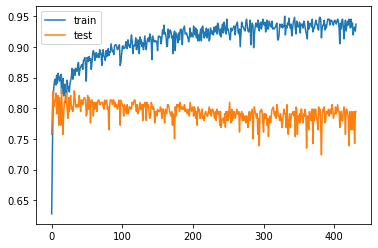

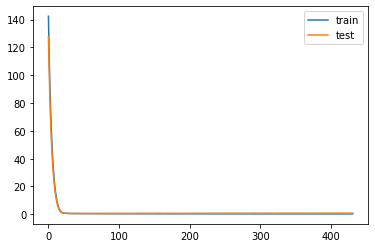

In [33]:
plot_history('accuracy')
plot_history('loss')

In [34]:
model_evaluation(model, X_train, y_train, X_test, y_test)

([0.4465337661640602, 0.8796148],
 [0.5683327157105973, 0.8171642],
 array([[143,  14],
        [ 35,  76]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.80      0.91      0.85       157\n           1       0.84      0.68      0.76       111\n\n    accuracy                           0.82       268\n   macro avg       0.82      0.80      0.80       268\nweighted avg       0.82      0.82      0.81       268\n')